In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from fit import likelihood, stat_fit
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)

# WM

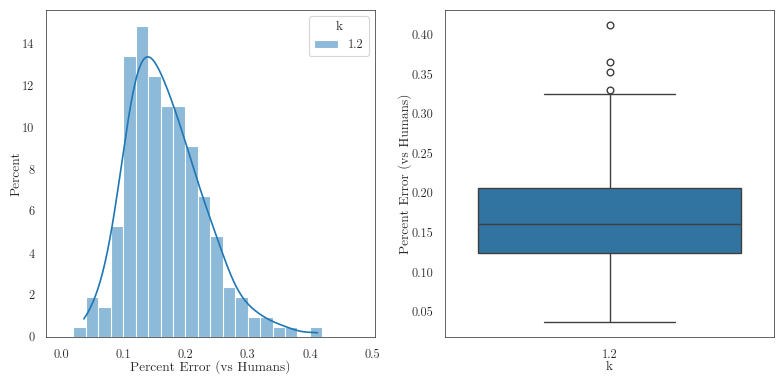

In [18]:
z05k12 = pd.read_pickle(f"data/WM_z05k12.pkl").query("type=='model-WM'")
combined = pd.concat([z05k12], ignore_index=True)

dfs = []
columns = ['type', 'sid', 'z', 'k', 'percent error']
for k in combined['k'].unique():
    for sid in combined['sid'].unique():
        subdata = combined.query("k==@k & sid==@sid")
        z = subdata['z'].unique()[0]
        errors = subdata['error'].to_numpy()
        if len(errors)==0:
            print(f"missing k={k} sid={sid}")
            continue
        percent_error = np.sum(errors) / len(errors)
        df = pd.DataFrame([['model-WM', sid, str(z), str(k), percent_error]], columns=columns)
        dfs.append(df)
reduced = pd.concat(dfs, ignore_index=True)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0.0, 0.5, 0.02)
ks = reduced['k'].unique()

sns.histplot(reduced, x='percent error', hue='k', ax=axes[0], palette=palette[:len(ks)], stat='percent', bins=bins, kde=True, common_norm=False)
sns.boxplot(reduced, x='k', y='percent error', hue='k', ax=axes[1], palette=palette[:len(ks)])
axes[0].set(xlabel="Percent Error (vs Humans)") 
axes[1].set(xlabel="k", ylabel='Percent Error (vs Humans)') 
plt.tight_layout()
fig.savefig("plots/wm_errors_zk.png", dpi=600)

# RL

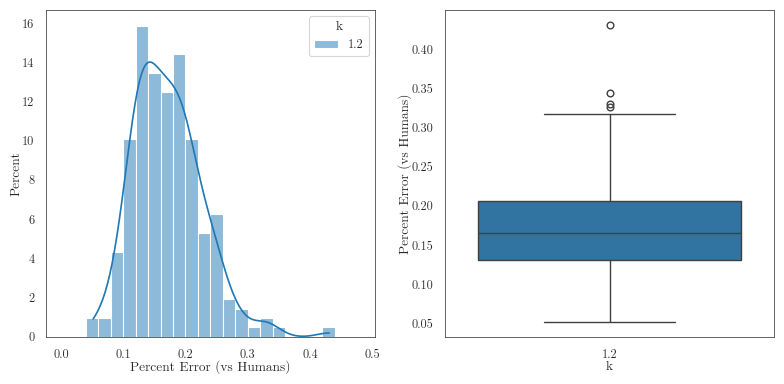

In [14]:
z05k12 = pd.read_pickle(f"data/RL_z05k12.pkl").query("type=='model-RL'")
combined = pd.concat([z05k12], ignore_index=True)

dfs = []
columns = ['type', 'sid', 'z', 'k', 'percent error']
for k in combined['k'].unique():
    for sid in combined['sid'].unique():
        subdata = combined.query("k==@k & sid==@sid")
        z = subdata['z'].unique()[0]
        errors = subdata['error'].to_numpy()
        if len(errors)==0:
            print(f"missing k={k} sid={sid}")
            continue
        percent_error = np.sum(errors) / len(errors)
        df = pd.DataFrame([['model-RL', sid, str(z), str(k), percent_error]], columns=columns)
        dfs.append(df)
reduced = pd.concat(dfs, ignore_index=True)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0.0, 0.5, 0.02)
ks = reduced['k'].unique()

sns.histplot(reduced, x='percent error', hue='k', ax=axes[0], palette=palette[:len(ks)], stat='percent', bins=bins, kde=True, common_norm=False)
sns.boxplot(reduced, x='k', y='percent error', hue='k', ax=axes[1], palette=palette[:len(ks)])
axes[0].set(xlabel="Percent Error (vs Humans)") 
axes[1].set(xlabel="k", ylabel='Percent Error (vs Humans)') 
plt.tight_layout()
fig.savefig("plots/rl_errors_zk.png", dpi=600)

# Statistical models

## Fit a model

In [ ]:
start = time.time()
model_type = "RL1rd"
sids = pd.read_pickle(f"data/behavior.pkl")['sid'].unique()
dfs = []
for sid in sids:
    print(sid)
    df = stat_fit(model_type, sid, save=False)
    dfs.append(df)
fitted = pd.concat(dfs, ignore_index=True)
fitted.to_pickle(f"data/fitted_{model_type}.pkl")
end = time.time()
print(f"runtime {(end-start)/60:.4} min")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
18
19
20
21
23
24
25
26
27
28
29
30
31
32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
102
103
104
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
134
135
136
137
138
140
141
142
143
144
145
146
147
148
149
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


/tmp/ipykernel_52939/4138429460.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([fitted_RL1, fitted_RL2, fitted_NEF_WM], ignore_index=True)
/tmp/ipykernel_52939/4138429460.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))


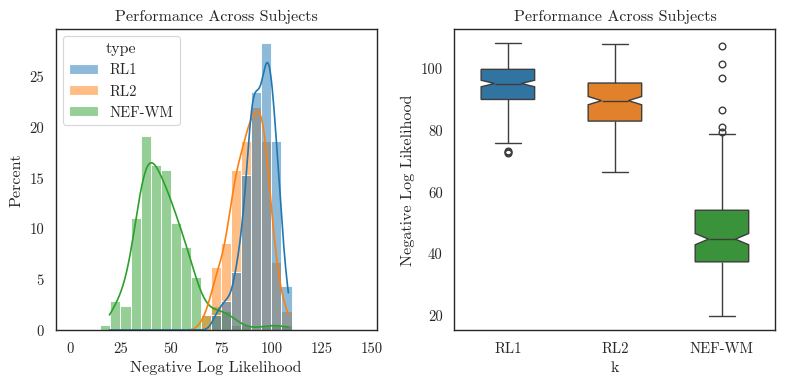

In [12]:
fitted_NEF_WM = pd.read_pickle(f"data/fitted_NEF-WM.pkl")
fitted_RL1 = pd.read_pickle(f"data/fitted_RL1.pkl")
fitted_RL2 = pd.read_pickle(f"data/fitted_RL2.pkl")
combined = pd.concat([fitted_RL1, fitted_RL2, fitted_NEF_WM], ignore_index=True)
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0, 150, 5)
types = combined['type'].unique()

sns.histplot(combined, x='neg-log-likelihood', hue='type', ax=axes[0], palette=palette[:len(types)],
             stat='percent', bins=bins, kde=True, common_norm=False)
sns.boxplot(combined, x='type', y='neg-log-likelihood', hue='type', ax=axes[1], palette=palette[:len(types)],
           notch=True, width=0.5)
axes[0].set(xlabel="Negative Log Likelihood", title="Performance Across Subjects") 
axes[1].set(xlabel="k", ylabel='Negative Log Likelihood', title="Performance Across Subjects") 
plt.tight_layout()
fig.savefig("plots/fitted.png", dpi=600)

## Rerun fitted models

In [9]:
# fitted = pd.read_pickle(f"data/RL1_all.pkl")
fitted = pd.read_pickle(f"data/NEF-WM_z05k12.pkl")
dfs = []
# model_types = ["RL1"]  # , "RL2"]
model_types = ["NEF-WM"]  # , "RL2"]
sids = pd.read_pickle(f"data/behavior.pkl")['sid'].unique()
for model_type in model_types:
    for sid in [1]:  # sids:
        print(f"{model_type}, {sid}")
        data = rerun(fitted, model_type, sid)
        dfs.append(data)
rerun_data = pd.concat(dfs, ignore_index=True)
rerun_data.to_pickle(f"data/rerun_fitted_mathematical_models.pkl")

NEF-WM, 1
